In [1]:
import tensorflow as tf
import numpy as np
from numpy.linalg import norm
import pickle
import tqdm
import os
import random
import time
import math
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings("ignore")

DEBUGMODE = False
CALCULATE_FEATURE_VECTORS = False
CALCULATE_NEAREST_NEIGHBOURS = True
CALCULATE_TSNE = True

physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# preprocess_input = tensorflow.keras.applications.resnet.preprocess_input
input_shape = (224, 224, 3)
# model = ResNet50(weights='imagenet',
#                  include_top=False,
#                  input_shape=input_shape,
#                  pooling='max')
model = tf.keras.models.load_model('resnet_finetuned/model.3_epochs')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50_input (InputLayer)  [(None, 224, 224, 3)]    0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [3]:
import matplotlib.pyplot as plt

def extract_features(img_path, model):
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1])
                        )
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

def extract_features_and_plot(img_path, model):
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1])
                        )
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
#     print("min-max", np.min(preprocessed_img[0]), np.max(preprocessed_img[0]))
#     print("plot min-max", np.min((preprocessed_img[0]+126.0)/280.0), np.max((preprocessed_img[0]+126.0)/280.0))
    plt.imshow((preprocessed_img[0]+126.0)/280.0, interpolation='lanczos')
    plt.show()
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = features / norm(flattened_features)
    return normalized_features

In [4]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):

    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

root_dir = 'extended-clean'
print(len(get_file_list(root_dir)))

filenames = sorted(get_file_list(root_dir))

class_ids = []

for filename in filenames:
    artist_unique_id = filename.split('\\')[-2].split('(')[-1][:-1]
    class_ids.append(artist_unique_id)

27175


In [5]:
features_pkl = 'features-pix-resnet_finetuned_3epochs.pickle'
filenames_pkl = 'filenames-pix_finetuned_3epochs.pickle'

In [5]:

import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [6]:
# LOAD

feature_list = pickle.load(open(features_pkl, 'rb'))
filenames = pickle.load(open(filenames_pkl, 'rb'))

In [7]:
num_images = len(feature_list)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  27175
Number of features per image =  2048


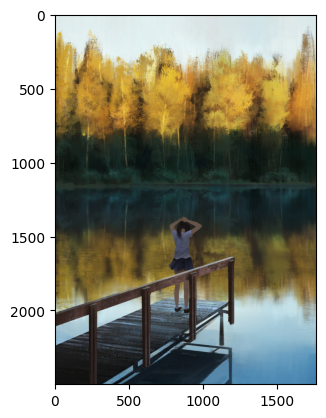

In [8]:
# Nearest Neighbours

neighbors = NearestNeighbors(n_neighbors=15,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

random_index = 153 #*253 # 4402
distances, indices = neighbors.kneighbors([feature_list[random_index]])
plt.imshow(mpimg.imread(filenames[random_index])) #, interpolation='lanczos')

In [6]:
def classname_filename(s: str):
    return s.split('\\')[-2] + '\\' + s.split('\\')[-1]

# Plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        # Save the plot in high definition
        plt.savefig('results/' + str(random.randint(0,10000))+'.jpg', format='jpg', dpi=200)

In [39]:
!mkdir results

A subdirectory or file results already exists.


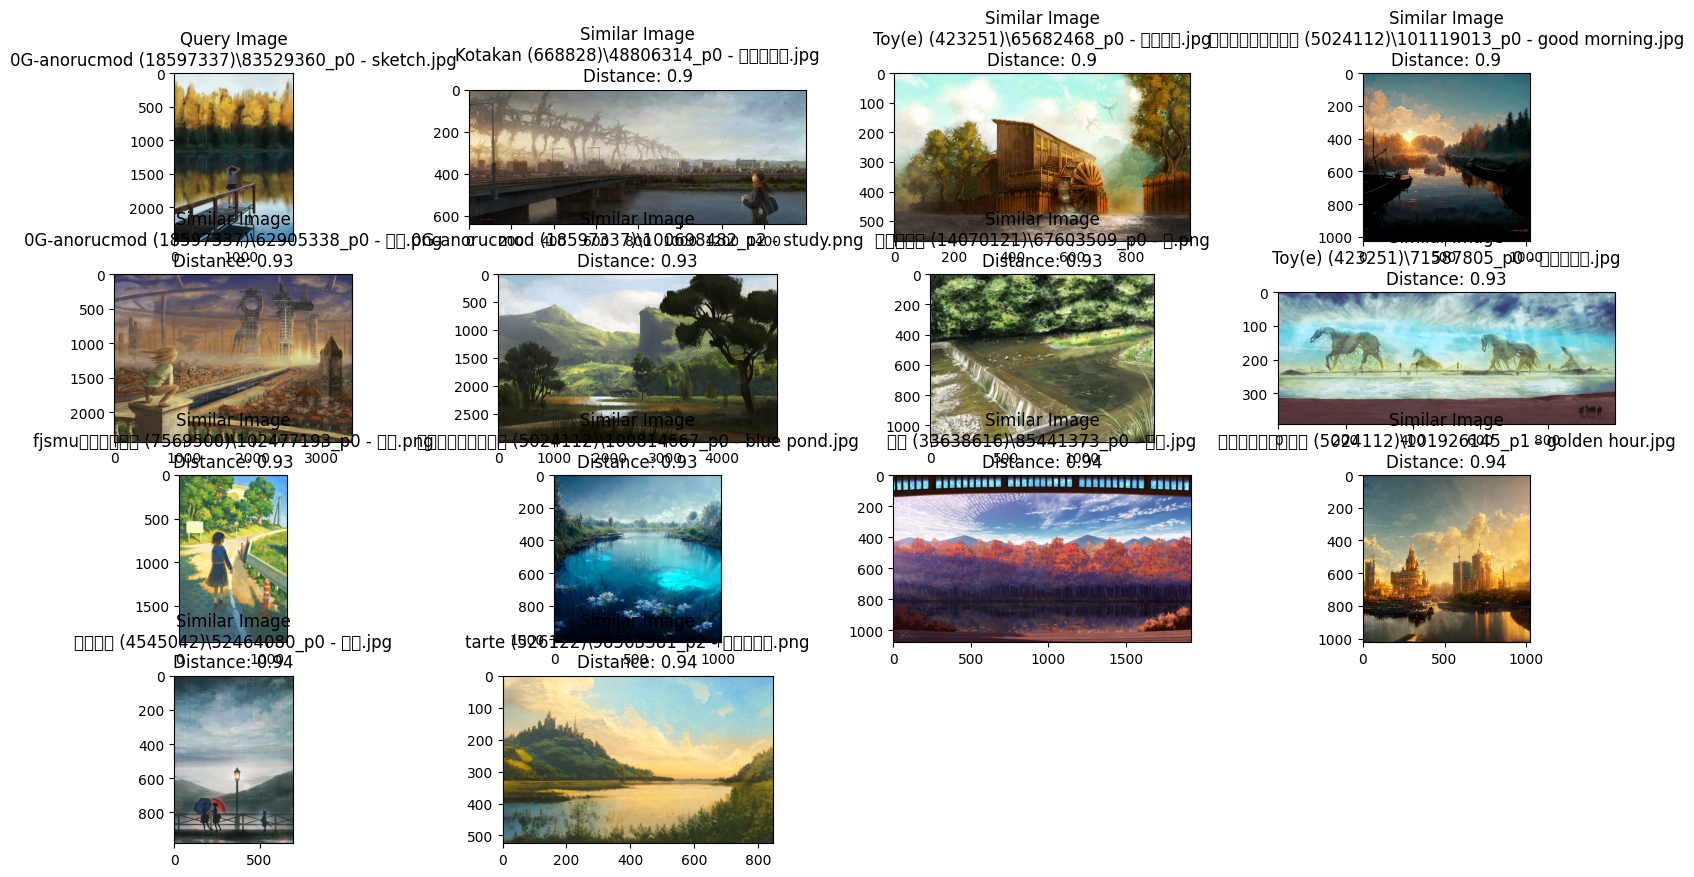

In [40]:
# Distances of the closest 5 images

similar_image_paths = [filenames[random_index]] + [filenames[indices[0][i]] for i in range(1, 14)] #TODO
plot_images(similar_image_paths, distances[0])
plt.show()

In [11]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from tqdm.contrib import tzip, tenumerate

def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1, dpi=400):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    
#     sequence = zip(x, y, image_paths)
    for x0, y0, image_path in tzip(x, y, image_paths):
#         x0, y0, image_path = sequence[i]
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
#         print(np.shape(image))
        if np.shape(image)[-1] < 3:
            continue
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()
    plt.savefig('results/cluster-' + str(random.randint(0,10000))+'.jpg', format='jpg')

def show_tsne(x, y, selected_filenames, zoom=.3, dpi=400):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=zoom, dpi=dpi, axis=axis)
    plt.show()

def tsne_to_grid_plotter_manual(x, y, selected_filenames, zoom=.58, dpi=400):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in tenumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=zoom, dpi=dpi, axis=axis)
    plt.show()

In [26]:
# Plotting t-SNE for a few thousand images

# Select first 1000 images

selected_features = feature_list[-1000:-1]
selected_filenames = filenames[-1000:-1]
selected_class_ids = class_ids[-1000:-1]

# Select 2000 images with random sampling
p = 10000/len(filenames)
mask = np.random.choice([True, False], size=np.shape(filenames), p=[p,1-p])
selected_filenames = np.array(filenames)[mask]
selected_features = np.array(feature_list)[mask]
selected_class_ids = np.array(class_ids)[mask]

In [27]:
from sklearn.manifold import TSNE

n_components = 2
verbose = 1
perplexity = 30 # 1150
learning_rate = 100 # 10 to 1000
early_exaggeration = 22.0 # 22.0
n_iter = 2000
metric = 'euclidean'

if CALCULATE_TSNE:
    time_start = time.time()
    print(time_start)

    tsne_results = TSNE(early_exaggeration=early_exaggeration, n_components=n_components, verbose=verbose, perplexity=perplexity, n_iter=n_iter, n_jobs=12, metric=metric, learning_rate=learning_rate).fit_transform(selected_features)

    print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

1679912983.673194
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9856 samples in 0.028s...
[t-SNE] Computed neighbors for 9856 samples in 6.152s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9856
[t-SNE] Computed conditional probabilities for sample 2000 / 9856
[t-SNE] Computed conditional probabilities for sample 3000 / 9856
[t-SNE] Computed conditional probabilities for sample 4000 / 9856
[t-SNE] Computed conditional probabilities for sample 5000 / 9856
[t-SNE] Computed conditional probabilities for sample 6000 / 9856
[t-SNE] Computed conditional probabilities for sample 7000 / 9856
[t-SNE] Computed conditional probabilities for sample 8000 / 9856
[t-SNE] Computed conditional probabilities for sample 9000 / 9856
[t-SNE] Computed conditional probabilities for sample 9856 / 9856
[t-SNE] Mean sigma: 0.231742
[t-SNE] KL divergence after 250 iterations with early exaggeration: 187.777756
[t-SNE] KL divergence after 2000 iterations: 2.278803
t-SNE done! Time el

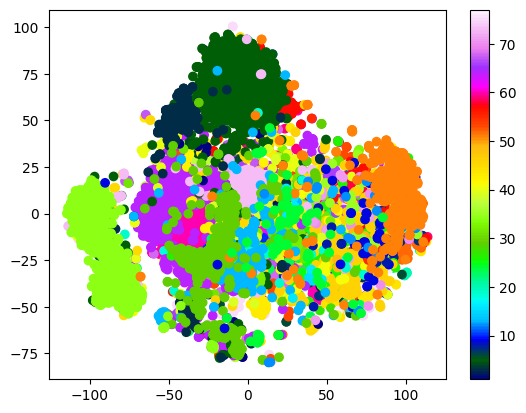

In [28]:
if CALCULATE_TSNE:
    d = dict([(y,x+1) for x,y in enumerate(sorted(set(selected_class_ids)))])

    color_map = plt.cm.get_cmap('gist_ncar')
    scatter_plot = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                               c=[d[x] for x in selected_class_ids],
                               cmap=color_map)
    plt.colorbar(scatter_plot)
    plt.show()

  0%|          | 0/9856 [00:00<?, ?it/s]

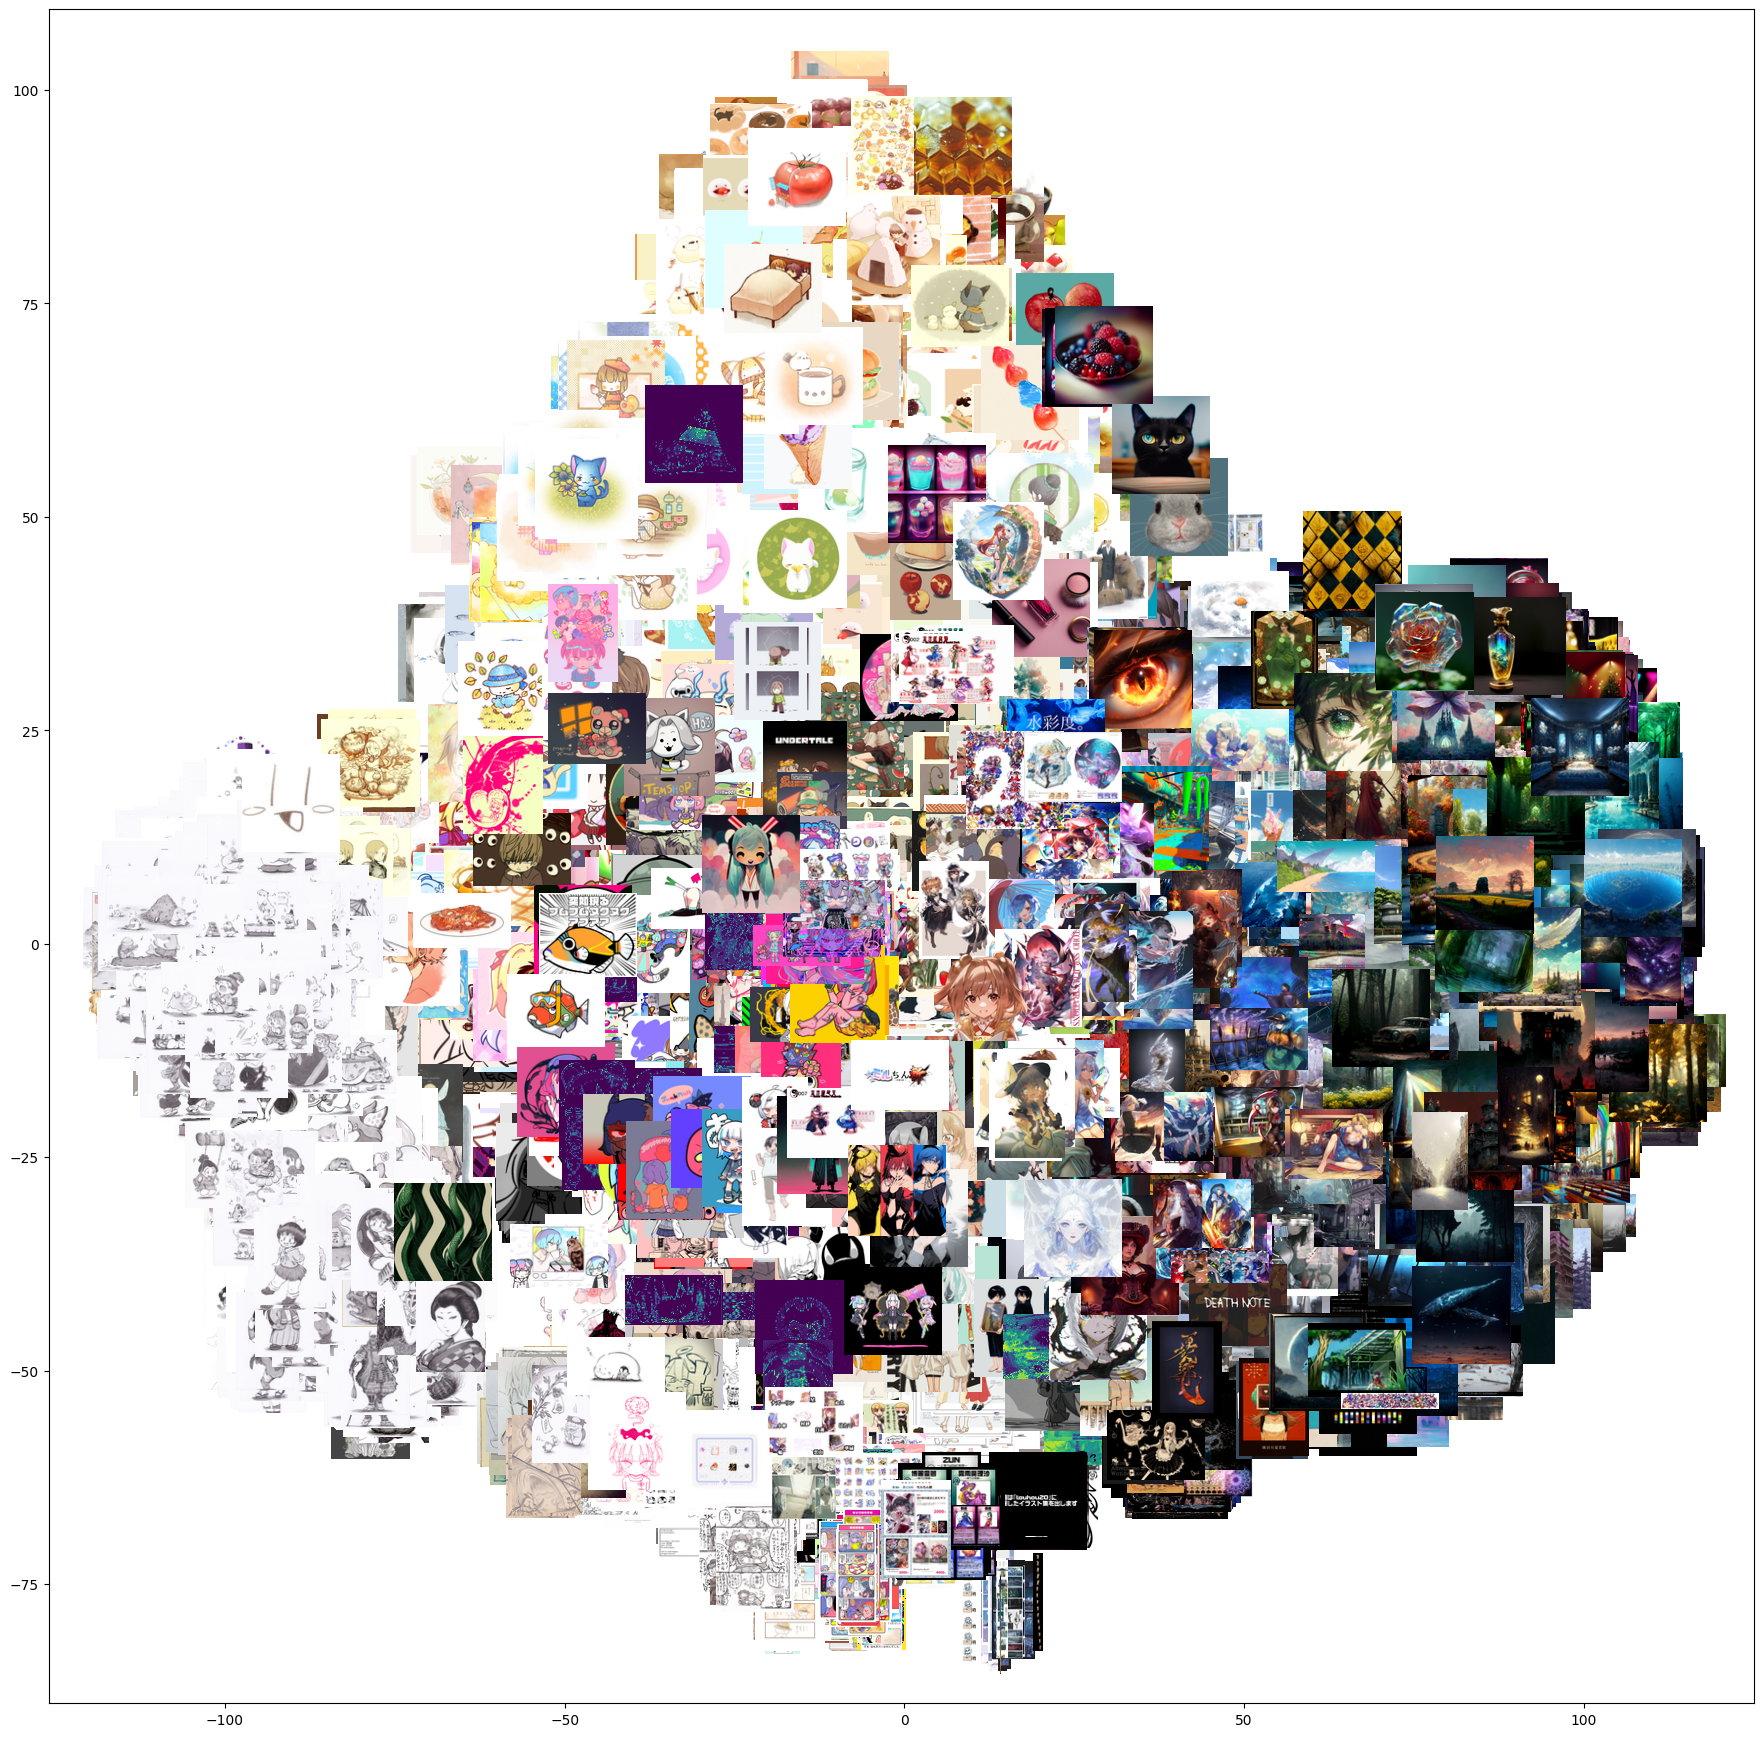

In [29]:
if CALCULATE_TSNE:
    show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames, zoom=.7)

  0%|          | 0/9856 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

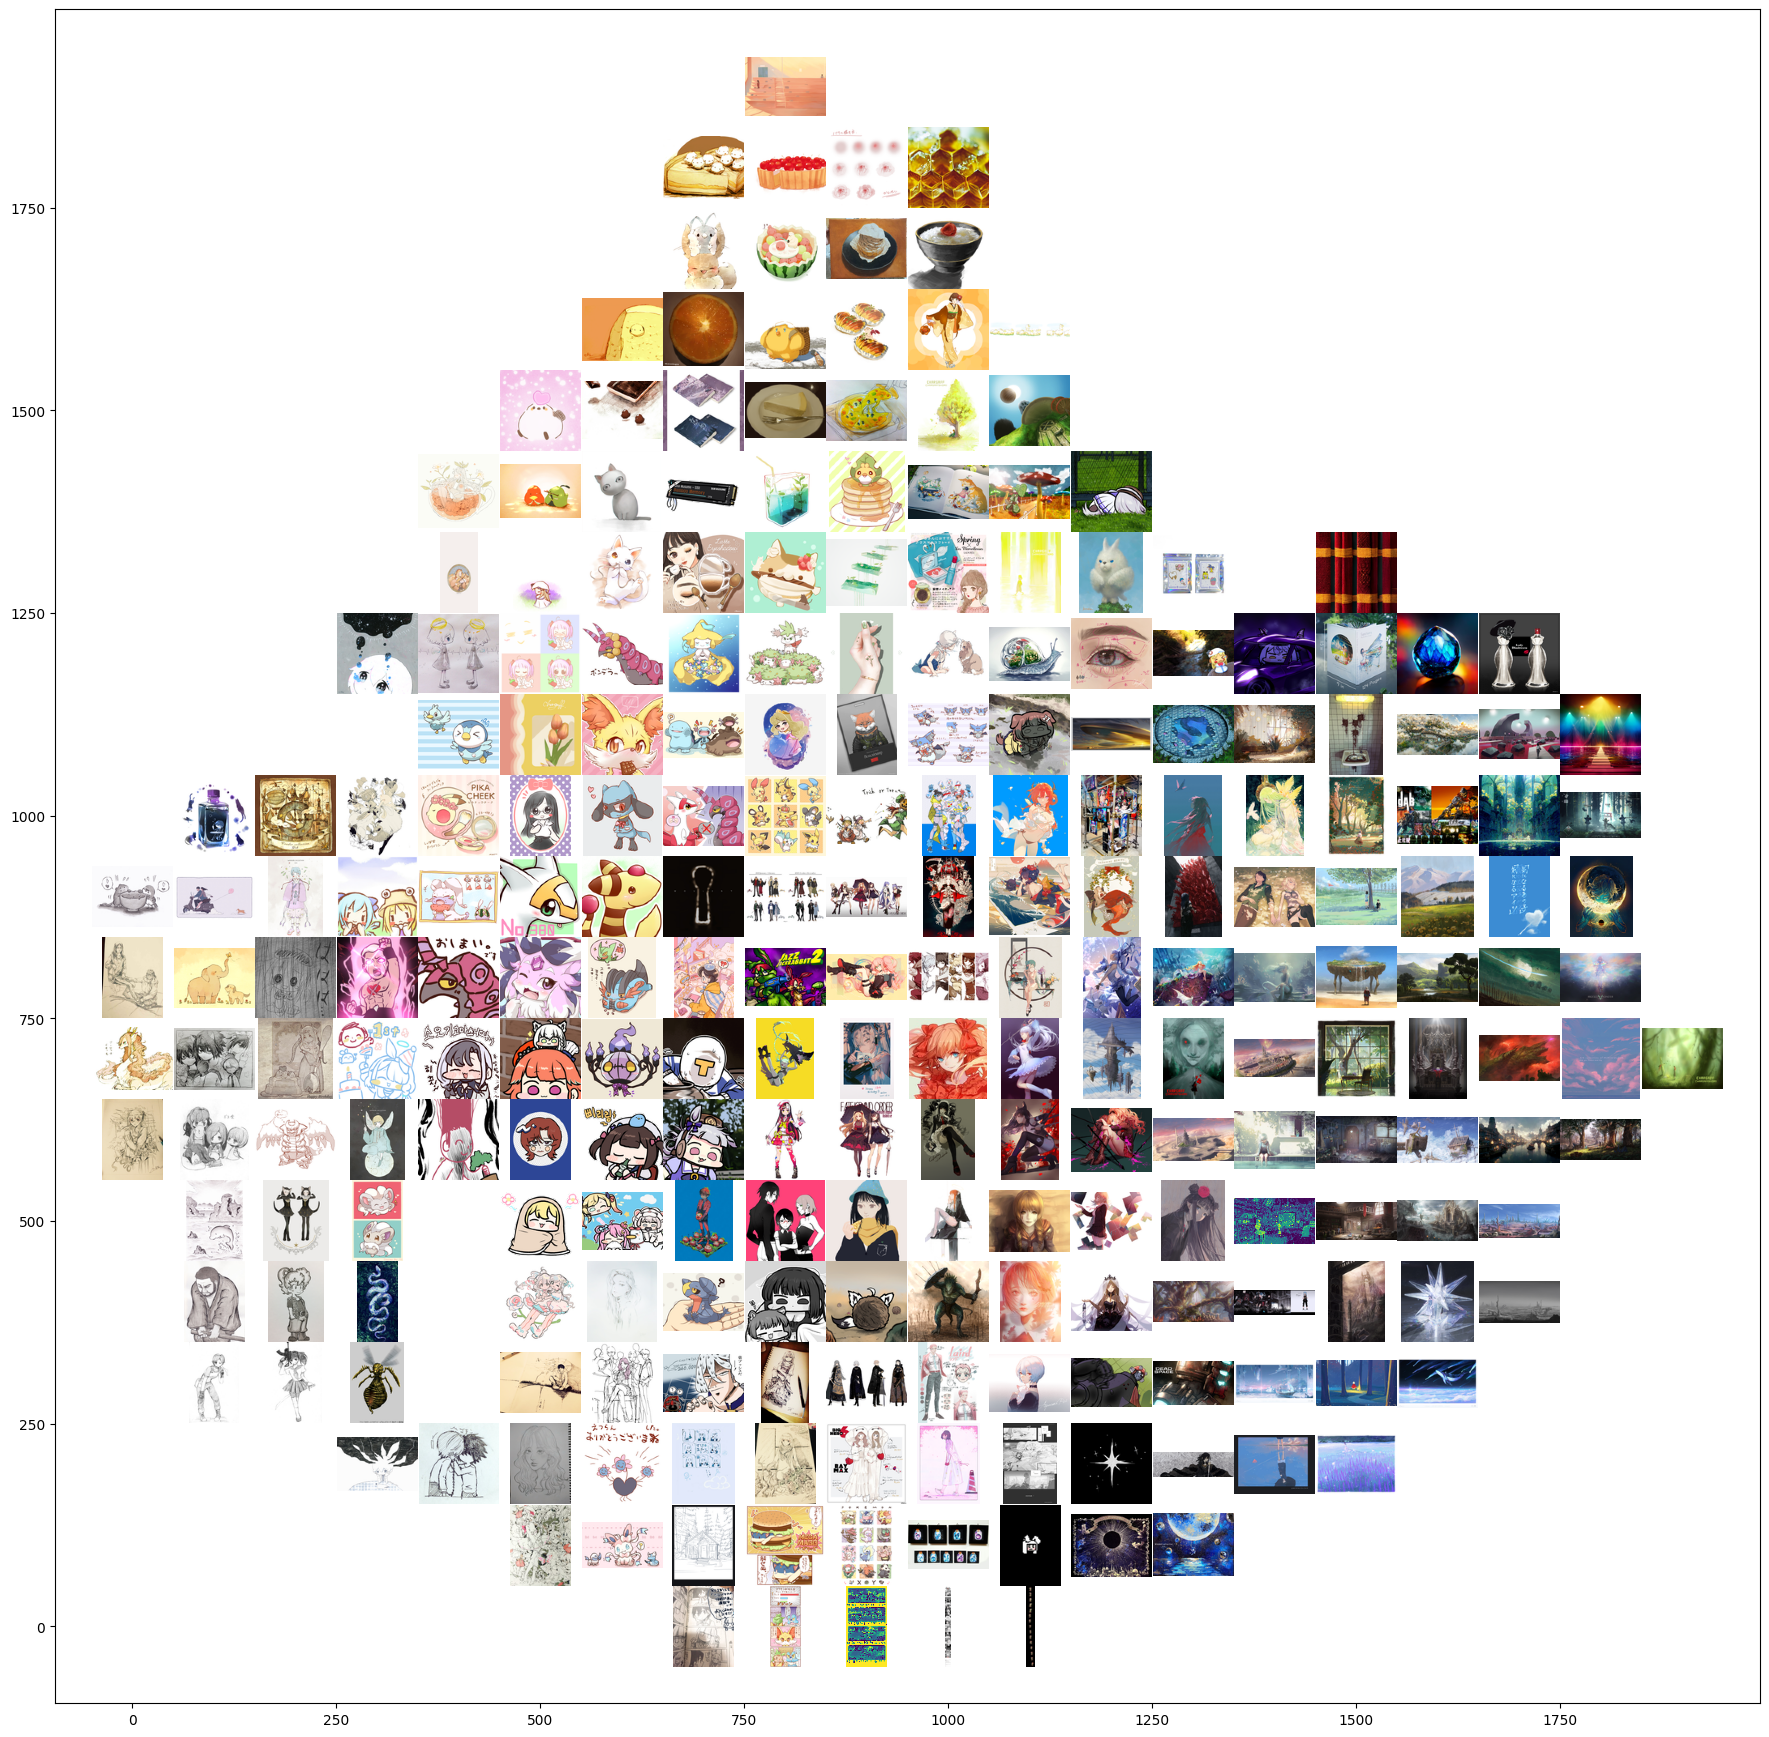

In [30]:
if CALCULATE_TSNE:
    tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames)

In [65]:
# Input shape = (224, 224, 3)
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, GlobalAvgPool2D, Reshape, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model

# input_image = Input(shape=(256, 256, 3))

# Encoder
encoder = tf.keras.Sequential([
    Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu", input_shape=(512, 512, 3)),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(256, kernel_size=3, strides=2, padding="same", activation="relu"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(768, kernel_size=3, strides=2, padding="same", activation="relu"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(2048, kernel_size=3, strides=2, padding="same", activation="relu"),
    GlobalAvgPool2D()
])
decoder = tf.keras.Sequential([
    tf.keras.layers.Reshape((1, 1, 2048)),
    Conv2DTranspose(768, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    UpSampling2D(size=(2, 2)),
    Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    UpSampling2D(size=(2, 2)),
    Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    UpSampling2D(size=(2, 2)),
    Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='sigmoid', padding='same'),
    UpSampling2D(size=(2, 2)),
    Conv2DTranspose(3, (3, 3), strides=(2, 2), activation='sigmoid', padding='same'),
    Flatten(),
    Reshape((512, 512, 3))
])
autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [66]:
encoder.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 8, 8, 256)      

In [67]:
decoder.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_12 (Reshape)        (None, 1, 1, 2048)        0         
                                                                 
 conv2d_transpose_30 (Conv2D  (None, 2, 2, 768)        14156544  
 Transpose)                                                      
                                                                 
 up_sampling2d_24 (UpSamplin  (None, 4, 4, 768)        0         
 g2D)                                                            
                                                                 
 conv2d_transpose_31 (Conv2D  (None, 8, 8, 256)        1769728   
 Transpose)                                                      
                                                                 
 up_sampling2d_25 (UpSamplin  (None, 16, 16, 256)      0         
 g2D)                                                

In [68]:
# autoencoder.fit(x_train, x_train,
#                 epochs=50,
#                 batch_size=128,
#                 shuffle=True,
#                 validation_data=(x_test, x_test))

In [69]:
from sklearn.model_selection import train_test_split

root_dir = 'extended-clean'
flist = get_file_list(root_dir)

# split into train and test
train, test = train_test_split(flist, test_size=0.2, random_state=42)

In [70]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1/255., validation_split=0.2, featurewise_center=True, featurewise_std_normalization=True
                                ).flow_from_directory(root_dir, target_size=(512, 512),
                                batch_size=8, subset='training', seed=42, shuffle=True, class_mode='input')

valid_gen = ImageDataGenerator(rescale=1/255., validation_split=0.2, featurewise_center=True, featurewise_std_normalization=True
                                ).flow_from_directory(root_dir, target_size=(512, 512), batch_size=8, seed=42, subset='validation', shuffle=False, class_mode='input')

num_classes = len(train_gen.class_indices)

assert num_classes == len(valid_gen.class_indices)

Found 21765 images belonging to 76 classes.
Found 5406 images belonging to 76 classes.


In [71]:
# %load_ext tensorboard
LOG_DIR = ".\log"

In [72]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(LOG_DIR,
                                                      histogram_freq=1,
                                                      write_graph=True,
                                                      write_grads=True,
                                                      write_images=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=5)

In [73]:
# %tensorboard --logdir {LOG_DIR}

In [74]:
autoencoder.fit(train_gen, epochs=2, validation_data=valid_gen, validation_steps=1, validation_freq=1, callbacks=[tensorboard_callback], batch_size=8)

Epoch 1/2
2721/2721 [==============================] - 1177s 422ms/step - loss: 0.6557 - val_loss: 0.7966
Epoch 2/2
2721/2721 [==============================] - 993s 365ms/step - loss: 0.6554 - val_loss: 0.7831
